# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [72]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [73]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [74]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

OPTUNA_PATH = '../optuna/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_RUS = OPTUNA_PATH + "optuna_rf_rus.log"
STUDY_PATH_SMOTE = OPTUNA_PATH + "optuna_rf_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_PATH + "optuna_rf_smote-tomek.log"

RANDOM_STATE = 38

### 0.3 Loading datasets

In [75]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Scaling & Validation Set**
Applying scaling to numerical features, and extracting a validation set.

In [76]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [ ]:
NUMERICAL_COLUMNS = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'age', 'num_inpatient', 'num_diagnoses', 'num_medications'
]

In [77]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [78]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45061, 1: 4522})
Test set: Counter({0: 19312, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [79]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [80]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2024-12-27 16:53:10,415] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [81]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-27 16:53:18,694] Trial 3 finished with value: 0.21756973472831792 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:18,791] Trial 1 finished with value: 0.2168124737195462 and parameters: {'max_depth': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.21756973472831792.


Cross validation F1-scores: [0.21502646 0.21849116 0.21976593 0.22490876 0.20965637]
Average F1-score: 0.21756973472831792
Cross validation F1-scores: [0.21582734 0.21436563 0.21911218 0.2211127  0.21364452]
Average F1-score: 0.2168124737195462
Cross validation F1-scores: [0.2128433  0.21374704 0.22116183 0.21963028 0.21226216]
Average F1-score: 0.215928919355812


[I 2024-12-27 16:53:18,892] Trial 4 finished with value: 0.215928919355812 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:18,956] Trial 0 finished with value: 0.215928919355812 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:19,131] Trial 6 finished with value: 0.21658210303704672 and parameters: {'max_depth': 12, 'min_samples_leaf': 54}. Best is trial 3 with value: 0.21756973472831792.


Cross validation F1-scores: [0.2128433  0.21374704 0.22116183 0.21963028 0.21226216]
Average F1-score: 0.215928919355812
Cross validation F1-scores: [0.21351296 0.21734452 0.21835708 0.22198136 0.21171459]
Average F1-score: 0.21658210303704672


[I 2024-12-27 16:53:19,197] Trial 11 finished with value: 0.21465517251782043 and parameters: {'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:19,200] Trial 7 finished with value: 0.21465517251782043 and parameters: {'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:19,320] Trial 10 finished with value: 0.21470099159757408 and parameters: {'max_depth': 14, 'min_samples_leaf': 38}. Best is trial 3 with value: 0.21756973472831792.


Cross validation F1-scores: [0.21056878 0.21453138 0.21922918 0.21718683 0.21175969]
Average F1-score: 0.21465517251782043
Cross validation F1-scores: [0.21056878 0.21453138 0.21922918 0.21718683 0.21175969]
Average F1-score: 0.21465517251782043
Cross validation F1-scores: [0.21096878 0.21546961 0.21794872 0.21777003 0.21134782]
Average F1-score: 0.21470099159757408


[I 2024-12-27 16:53:19,453] Trial 9 finished with value: 0.21447831363338157 and parameters: {'max_depth': 12, 'min_samples_leaf': 34}. Best is trial 3 with value: 0.21756973472831792.


Cross validation F1-scores: [0.21376812 0.2137045  0.21831714 0.21503087 0.21157095]
Average F1-score: 0.21447831363338157


[I 2024-12-27 16:53:19,733] Trial 2 finished with value: 0.21284243568797762 and parameters: {'max_depth': 18, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:19,769] Trial 5 finished with value: 0.21284243568797762 and parameters: {'max_depth': 18, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.21756973472831792.
[I 2024-12-27 16:53:19,920] Trial 8 finished with value: 0.21365987365702283 and parameters: {'max_depth': 18, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.21756973472831792.


Cross validation F1-scores: [0.21407096 0.21239687 0.21579487 0.21201862 0.20993086]
Average F1-score: 0.21284243568797762
Cross validation F1-scores: [0.21407096 0.21239687 0.21579487 0.21201862 0.20993086]
Average F1-score: 0.21284243568797762
Cross validation F1-scores: [0.21213339 0.21221053 0.22013478 0.21492158 0.2088991 ]
Average F1-score: 0.21365987365702283


[I 2024-12-27 16:53:27,528] Trial 21 finished with value: 0.21872033164181431 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.21872033164181431.
[I 2024-12-27 16:53:27,530] Trial 14 finished with value: 0.21555368060419444 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 21 with value: 0.21872033164181431.
[I 2024-12-27 16:53:27,602] Trial 22 finished with value: 0.21879295419909614 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:27,617] Trial 15 finished with value: 0.21609822429027276 and parameters: {'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:27,625] Trial 23 finished with value: 0.21910181338881332 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:27,665] Trial 13 finished with value: 0.2145228270252

Cross validation F1-scores: [0.21740083 0.21585394 0.22176213 0.22647754 0.21210721]
Average F1-score: 0.21872033164181431
Cross validation F1-scores: [0.21266134 0.21671018 0.21803889 0.21830065 0.21205734]
Average F1-score: 0.21555368060419444
Cross validation F1-scores: [0.21784777 0.21583742 0.22206928 0.22566996 0.21254034]
Average F1-score: 0.21879295419909614
Cross validation F1-scores: [0.21764706 0.21672504 0.21912437 0.21469174 0.21230291]
Average F1-score: 0.21609822429027276
Cross validation F1-scores: [0.21917211 0.21631702 0.22242775 0.22501184 0.21258035]
Average F1-score: 0.21910181338881332
Cross validation F1-scores: [0.21334415 0.21484458 0.21973001 0.21463623 0.21005917]
Average F1-score: 0.21452282702524803


[I 2024-12-27 16:53:27,807] Trial 16 finished with value: 0.21483399102991724 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:27,926] Trial 17 finished with value: 0.21597836678734644 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 23 with value: 0.21910181338881332.


Cross validation F1-scores: [0.21188839 0.21427032 0.2201873  0.21667026 0.21115368]
Average F1-score: 0.21483399102991724
Cross validation F1-scores: [0.21212121 0.21626374 0.21808173 0.22064057 0.21278459]
Average F1-score: 0.21597836678734644


[I 2024-12-27 16:53:27,998] Trial 20 finished with value: 0.21522923603530933 and parameters: {'max_depth': 12, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:28,138] Trial 18 finished with value: 0.21377381625317513 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 23 with value: 0.21910181338881332.


Cross validation F1-scores: [0.21182665 0.2162395  0.21841004 0.21765734 0.21201264]
Average F1-score: 0.21522923603530933
Cross validation F1-scores: [0.2121583  0.21402531 0.21901776 0.21205643 0.21161127]
Average F1-score: 0.21377381625317513


[I 2024-12-27 16:53:28,264] Trial 19 finished with value: 0.21562508464270672 and parameters: {'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.21910181338881332.
[I 2024-12-27 16:53:28,382] Trial 12 finished with value: 0.2098971669738368 and parameters: {'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 23 with value: 0.21910181338881332.


Cross validation F1-scores: [0.21558387 0.21029476 0.22120618 0.21561507 0.21542553]
Average F1-score: 0.21562508464270672
Cross validation F1-scores: [0.20977069 0.21138211 0.21840937 0.20481675 0.20510691]
Average F1-score: 0.2098971669738368


[I 2024-12-27 16:53:34,395] Trial 29 finished with value: 0.21960834046767386 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21929246 0.2155633  0.22352941 0.2256361  0.21402043]
Average F1-score: 0.21960834046767386


[I 2024-12-27 16:53:35,065] Trial 35 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197


[I 2024-12-27 16:53:35,307] Trial 25 finished with value: 0.21493807570387347 and parameters: {'max_depth': 28, 'min_samples_leaf': 48}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21351735 0.21558442 0.21887881 0.21591398 0.21079582]
Average F1-score: 0.21493807570387347


[I 2024-12-27 16:53:36,243] Trial 26 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:36,246] Trial 27 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:36,318] Trial 28 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:36,400] Trial 31 finished with value: 0.212608588458306 and parameters: {'max_depth': 26, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306
Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306
Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306
Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306


[I 2024-12-27 16:53:36,456] Trial 30 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306


[I 2024-12-27 16:53:36,758] Trial 33 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:36,841] Trial 34 finished with value: 0.212608588458306 and parameters: {'max_depth': 28, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306
Cross validation F1-scores: [0.21301301 0.21519251 0.21960625 0.20810469 0.20712648]
Average F1-score: 0.212608588458306


[I 2024-12-27 16:53:37,854] Trial 24 finished with value: 0.2022899092060379 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.20481692 0.20350877 0.21150135 0.19608626 0.19553624]
Average F1-score: 0.2022899092060379


[I 2024-12-27 16:53:38,172] Trial 32 finished with value: 0.20416836178582026 and parameters: {'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.20770585 0.203874   0.21240638 0.199001   0.19785459]
Average F1-score: 0.20416836178582026


[I 2024-12-27 16:53:42,749] Trial 36 finished with value: 0.21960834046767386 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21929246 0.2155633  0.22352941 0.2256361  0.21402043]
Average F1-score: 0.21960834046767386


[I 2024-12-27 16:53:43,588] Trial 37 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197


[I 2024-12-27 16:53:44,040] Trial 38 finished with value: 0.21960834046767386 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21929246 0.2155633  0.22352941 0.2256361  0.21402043]
Average F1-score: 0.21960834046767386


[I 2024-12-27 16:53:44,982] Trial 39 finished with value: 0.21960834046767386 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:45,075] Trial 40 finished with value: 0.21960834046767386 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:45,163] Trial 41 finished with value: 0.21923661292453334 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21929246 0.2155633  0.22352941 0.2256361  0.21402043]
Average F1-score: 0.21960834046767386
Cross validation F1-scores: [0.21929246 0.2155633  0.22352941 0.2256361  0.21402043]
Average F1-score: 0.21960834046767386
Cross validation F1-scores: [0.21952297 0.21691176 0.22237227 0.22495776 0.2124183 ]
Average F1-score: 0.21923661292453334
Cross validation F1-scores: [0.21880416 0.21687861 0.22273355 0.22572178 0.21205152]
Average F1-score: 0.2192379245937107


[I 2024-12-27 16:53:45,204] Trial 43 finished with value: 0.2192379245937107 and parameters: {'max_depth': 4, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:45,266] Trial 42 finished with value: 0.21907651919231266 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21787832 0.21605505 0.22307692 0.22475728 0.21361502]
Average F1-score: 0.21907651919231266


[I 2024-12-27 16:53:45,522] Trial 45 finished with value: 0.21907651919231266 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:45,599] Trial 44 finished with value: 0.21907651919231266 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21787832 0.21605505 0.22307692 0.22475728 0.21361502]
Average F1-score: 0.21907651919231266
Cross validation F1-scores: [0.21787832 0.21605505 0.22307692 0.22475728 0.21361502]
Average F1-score: 0.21907651919231266


[I 2024-12-27 16:53:46,889] Trial 46 finished with value: 0.21907651919231266 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:47,060] Trial 47 finished with value: 0.21907651919231266 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21787832 0.21605505 0.22307692 0.22475728 0.21361502]
Average F1-score: 0.21907651919231266
Cross validation F1-scores: [0.21787832 0.21605505 0.22307692 0.22475728 0.21361502]
Average F1-score: 0.21907651919231266


[I 2024-12-27 16:53:51,373] Trial 48 finished with value: 0.2177243553455991 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21345215 0.21642468 0.22207564 0.22498242 0.21168688]
Average F1-score: 0.2177243553455991


[I 2024-12-27 16:53:52,065] Trial 49 finished with value: 0.2177243553455991 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21345215 0.21642468 0.22207564 0.22498242 0.21168688]
Average F1-score: 0.2177243553455991


[I 2024-12-27 16:53:52,556] Trial 50 finished with value: 0.21811017041514097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21396919 0.21732283 0.22110333 0.2244898  0.2136657 ]
Average F1-score: 0.21811017041514097


[I 2024-12-27 16:53:53,413] Trial 51 finished with value: 0.21811017041514097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:53,483] Trial 52 finished with value: 0.21759351448034886 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21396919 0.21732283 0.22110333 0.2244898  0.2136657 ]
Average F1-score: 0.21811017041514097
Cross validation F1-scores: [0.21375346 0.21527306 0.21838317 0.22765757 0.21290032]
Average F1-score: 0.21759351448034886
Cross validation F1-scores: [0.21396919 0.21732283 0.22110333 0.2244898  0.2136657 ]
Average F1-score: 0.21811017041514097


[I 2024-12-27 16:53:53,608] Trial 54 finished with value: 0.21811017041514097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:53,747] Trial 53 finished with value: 0.21811017041514097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:53,795] Trial 55 finished with value: 0.21777030664032188 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21396919 0.21732283 0.22110333 0.2244898  0.2136657 ]
Average F1-score: 0.21811017041514097
Cross validation F1-scores: [0.21541081 0.21680823 0.22163704 0.22360248 0.21139297]
Average F1-score: 0.21777030664032188


[I 2024-12-27 16:53:54,155] Trial 56 finished with value: 0.21777030664032188 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:54,159] Trial 57 finished with value: 0.21777030664032188 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21541081 0.21680823 0.22163704 0.22360248 0.21139297]
Average F1-score: 0.21777030664032188
Cross validation F1-scores: [0.21541081 0.21680823 0.22163704 0.22360248 0.21139297]
Average F1-score: 0.21777030664032188


[I 2024-12-27 16:53:55,490] Trial 58 finished with value: 0.21759351448034886 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:53:55,590] Trial 59 finished with value: 0.21759351448034886 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21375346 0.21527306 0.21838317 0.22765757 0.21290032]
Average F1-score: 0.21759351448034886
Cross validation F1-scores: [0.21375346 0.21527306 0.21838317 0.22765757 0.21290032]
Average F1-score: 0.21759351448034886


[I 2024-12-27 16:53:59,838] Trial 60 finished with value: 0.21777030664032188 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21541081 0.21680823 0.22163704 0.22360248 0.21139297]
Average F1-score: 0.21777030664032188


[I 2024-12-27 16:54:01,028] Trial 61 finished with value: 0.21632735364803324 and parameters: {'max_depth': 8, 'min_samples_leaf': 22}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21394381 0.21276596 0.21999146 0.22063421 0.21430133]
Average F1-score: 0.21632735364803324


[I 2024-12-27 16:54:01,645] Trial 62 finished with value: 0.21704549666677395 and parameters: {'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21444835 0.21559233 0.22111855 0.22041186 0.21365639]
Average F1-score: 0.21704549666677395


[I 2024-12-27 16:54:02,491] Trial 63 finished with value: 0.21686432909038422 and parameters: {'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:02,533] Trial 64 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:02,602] Trial 65 finished with value: 0.21704549666677395 and parameters: {'max_depth': 8, 'min_samples_leaf': 24}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.2173913  0.21388286 0.2214442  0.21596032 0.21564295]
Average F1-score: 0.21686432909038422
Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985
Cross validation F1-scores: [0.21444835 0.21559233 0.22111855 0.22041186 0.21365639]
Average F1-score: 0.21704549666677395


[I 2024-12-27 16:54:02,855] Trial 67 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:03,022] Trial 66 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985
Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985


[I 2024-12-27 16:54:03,138] Trial 68 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:03,260] Trial 69 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985
Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985


[I 2024-12-27 16:54:04,420] Trial 70 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:04,469] Trial 71 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985
Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985


[I 2024-12-27 16:54:08,644] Trial 72 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985


[I 2024-12-27 16:54:09,790] Trial 73 finished with value: 0.21814820936759985 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21729119 0.21760283 0.22338114 0.21704036 0.21542553]
Average F1-score: 0.21814820936759985


[I 2024-12-27 16:54:11,383] Trial 74 finished with value: 0.20996393384121817 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.20996016 0.21146808 0.21808618 0.20465506 0.20565019]
Average F1-score: 0.20996393384121817


[I 2024-12-27 16:54:11,613] Trial 76 finished with value: 0.21438587039605145 and parameters: {'max_depth': 16, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:11,692] Trial 78 finished with value: 0.21500160209245936 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21541542 0.2150448  0.22033556 0.21254209 0.20859149]
Average F1-score: 0.21438587039605145
Cross validation F1-scores: [0.21383391 0.21462163 0.22032841 0.21295896 0.21326509]
Average F1-score: 0.21500160209245936


[I 2024-12-27 16:54:11,847] Trial 75 finished with value: 0.21438587039605145 and parameters: {'max_depth': 16, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:11,888] Trial 77 finished with value: 0.21507152800092966 and parameters: {'max_depth': 20, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:12,019] Trial 80 finished with value: 0.21500160209245936 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21541542 0.2150448  0.22033556 0.21254209 0.20859149]
Average F1-score: 0.21438587039605145
Cross validation F1-scores: [0.21721802 0.21749113 0.21859246 0.21289228 0.20916376]
Average F1-score: 0.21507152800092966
Cross validation F1-scores: [0.21383391 0.21462163 0.22032841 0.21295896 0.21326509]
Average F1-score: 0.21500160209245936


[I 2024-12-27 16:54:12,082] Trial 82 finished with value: 0.21923661292453334 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:12,096] Trial 83 finished with value: 0.21879295419909614 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:12,180] Trial 79 finished with value: 0.21535511850040928 and parameters: {'max_depth': 22, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21952297 0.21691176 0.22237227 0.22495776 0.2124183 ]
Average F1-score: 0.21923661292453334
Cross validation F1-scores: [0.21784777 0.21583742 0.22206928 0.22566996 0.21254034]
Average F1-score: 0.21879295419909614
Cross validation F1-scores: [0.21743467 0.21679198 0.21859246 0.21492158 0.20903491]
Average F1-score: 0.21535511850040928


[I 2024-12-27 16:54:12,333] Trial 81 finished with value: 0.21535511850040928 and parameters: {'max_depth': 22, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21743467 0.21679198 0.21859246 0.21492158 0.20903491]
Average F1-score: 0.21535511850040928


[I 2024-12-27 16:54:17,166] Trial 84 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197


[I 2024-12-27 16:54:18,181] Trial 85 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197


[I 2024-12-27 16:54:20,051] Trial 86 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:20,208] Trial 87 finished with value: 0.2193280791834197 and parameters: {'max_depth': 4, 'min_samples_leaf': 14}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197
Cross validation F1-scores: [0.21907502 0.21626617 0.22257336 0.22531828 0.21340756]
Average F1-score: 0.2193280791834197


[I 2024-12-27 16:54:20,333] Trial 88 finished with value: 0.21879295419909614 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:20,336] Trial 89 finished with value: 0.21879295419909614 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.21960834046767386.
[I 2024-12-27 16:54:20,411] Trial 90 finished with value: 0.21879295419909614 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.21960834046767386.


Cross validation F1-scores: [0.21784777 0.21583742 0.22206928 0.22566996 0.21254034]
Average F1-score: 0.21879295419909614
Cross validation F1-scores: [0.21784777 0.21583742 0.22206928 0.22566996 0.21254034]
Average F1-score: 0.21879295419909614
Cross validation F1-scores: [0.21784777 0.21583742 0.22206928 0.22566996 0.21254034]
Average F1-score: 0.21879295419909614


[I 2024-12-27 16:54:20,558] Trial 91 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:20,599] Trial 92 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:20,654] Trial 93 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:20,661] Trial 94 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:20,712] Trial 95 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.


Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887


[I 2024-12-27 16:54:21,774] Trial 96 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:21,921] Trial 97 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.


Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887


[I 2024-12-27 16:54:22,216] Trial 98 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.
[I 2024-12-27 16:54:22,228] Trial 99 finished with value: 0.21972573966991887 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.21972573966991887.


Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887
Cross validation F1-scores: [0.21953897 0.21675563 0.22313297 0.2259914  0.21320973]
Average F1-score: 0.21972573966991887


In [82]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 91
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 10}
Best Value: 0.21972573966991887


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [83]:
optuna.visualization.plot_optimization_history(study)

In [84]:
optuna.visualization.plot_slice(study)

In [85]:
optuna.visualization.plot_param_importances(study)

In [86]:
optuna.visualization.plot_parallel_coordinate(study)

In [87]:
optuna.visualization.plot_contour(study)

In [88]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [89]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=38))])

In [90]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [91]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6712784623762177
Test accuracy:  0.673364705882353


In [92]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.69      0.79     19312
      Early-readmission       0.14      0.50      0.22      1938

               accuracy                           0.67     21250
              macro avg       0.54      0.60      0.51     21250
           weighted avg       0.86      0.67      0.74     21250



<Axes: >

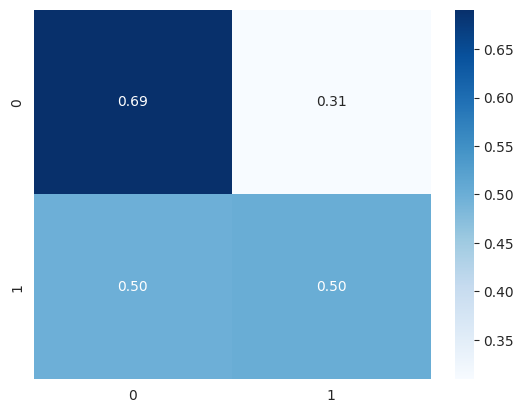

In [126]:
cm_rus = confusion_matrix(y_test, y_test_pred_rus, normalize='true')
sns.heatmap(cm_rus, annot=True, fmt=".2f", cmap='Blues')

## **3. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [94]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [95]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2024-12-27 16:54:22,998] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [96]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-27 16:55:01,036] Trial 0 finished with value: 0.18412085401949496 and parameters: {'max_depth': 12, 'min_samples_leaf': 58}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.1996912  0.18585005 0.18308351 0.1718485  0.180131  ]
Average F1-score: 0.18412085401949496


[I 2024-12-27 16:55:03,574] Trial 4 finished with value: 0.16655986834073938 and parameters: {'max_depth': 14, 'min_samples_leaf': 48}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.18375815 0.16646707 0.16324134 0.15276894 0.16656385]
Average F1-score: 0.16655986834073938


[I 2024-12-27 16:55:04,715] Trial 3 finished with value: 0.1473723511823698 and parameters: {'max_depth': 14, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.15039578 0.14719174 0.14923384 0.13950276 0.15053763]
Average F1-score: 0.1473723511823698


[I 2024-12-27 16:55:06,480] Trial 9 finished with value: 0.13777527253161956 and parameters: {'max_depth': 16, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.1504788  0.1398218  0.14415675 0.12787356 0.12654545]
Average F1-score: 0.13777527253161956


[I 2024-12-27 16:55:07,306] Trial 8 finished with value: 0.13779744280687428 and parameters: {'max_depth': 28, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.18412085401949496.
[I 2024-12-27 16:55:07,456] Trial 5 finished with value: 0.12693043483991379 and parameters: {'max_depth': 18, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.14266118 0.13099257 0.13469985 0.13052937 0.15010424]
Average F1-score: 0.13779744280687428
Cross validation F1-scores: [0.13129103 0.12553495 0.13069909 0.12965723 0.11746988]
Average F1-score: 0.12693043483991379


[I 2024-12-27 16:55:09,283] Trial 2 finished with value: 0.114336260184603 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.11471698 0.11466865 0.11902897 0.12074303 0.10252366]
Average F1-score: 0.114336260184603


[I 2024-12-27 16:55:09,831] Trial 1 finished with value: 0.10182315759829152 and parameters: {'max_depth': 22, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.10651828 0.10268562 0.10128617 0.09862571 0.1       ]
Average F1-score: 0.10182315759829152


[I 2024-12-27 16:55:10,352] Trial 11 finished with value: 0.09805668196281353 and parameters: {'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.09500805 0.09335443 0.11065907 0.09547325 0.0957886 ]
Average F1-score: 0.09805668196281353


[I 2024-12-27 16:55:11,740] Trial 6 finished with value: 0.08074517778084345 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.08616404 0.08521303 0.0758214  0.08020478 0.07632264]
Average F1-score: 0.08074517778084345


[I 2024-12-27 16:55:14,716] Trial 10 finished with value: 0.05756786548738698 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.0557053  0.05765766 0.05866178 0.0557053  0.06010929]
Average F1-score: 0.05756786548738698


[I 2024-12-27 16:55:16,690] Trial 7 finished with value: 0.055373011327521336 and parameters: {'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.18412085401949496.


Cross validation F1-scores: [0.05860806 0.05095541 0.04651163 0.05277525 0.06801471]
Average F1-score: 0.055373011327521336


[I 2024-12-27 16:55:30,872] Trial 20 finished with value: 0.2070863212231792 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 20 with value: 0.2070863212231792.


Cross validation F1-scores: [0.20974111 0.2047172  0.21004146 0.20985222 0.20107962]
Average F1-score: 0.2070863212231792


[I 2024-12-27 16:55:31,970] Trial 21 finished with value: 0.2074517587464924 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 21 with value: 0.2074517587464924.


Cross validation F1-scores: [0.20887166 0.20829493 0.20836158 0.21181773 0.19991289]
Average F1-score: 0.2074517587464924


[I 2024-12-27 16:55:34,250] Trial 17 finished with value: 0.21239382007590163 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.22191706 0.2122281  0.21213873 0.20996756 0.20571765]
Average F1-score: 0.21239382007590163


[I 2024-12-27 16:55:35,294] Trial 13 finished with value: 0.21118333127958522 and parameters: {'max_depth': 8, 'min_samples_leaf': 48}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.22378139 0.20932009 0.21189024 0.20418006 0.20674487]
Average F1-score: 0.21118333127958522


[I 2024-12-27 16:55:41,027] Trial 14 finished with value: 0.19386443191278085 and parameters: {'max_depth': 10, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.21192053 0.19056879 0.19117647 0.17761807 0.1980383 ]
Average F1-score: 0.19386443191278085


[I 2024-12-27 16:55:43,376] Trial 23 finished with value: 0.21160755956117172 and parameters: {'max_depth': 6, 'min_samples_leaf': 60}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.21706326 0.2109174  0.21643664 0.21115419 0.2024663 ]
Average F1-score: 0.21160755956117172


[I 2024-12-27 16:55:46,369] Trial 12 finished with value: 0.1352999859710454 and parameters: {'max_depth': 30, 'min_samples_leaf': 44}. Best is trial 17 with value: 0.21239382007590163.
[I 2024-12-27 16:55:46,373] Trial 15 finished with value: 0.16946497005235944 and parameters: {'max_depth': 12, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.14814815 0.12033195 0.14295725 0.12879884 0.13626374]
Average F1-score: 0.1352999859710454
Cross validation F1-scores: [0.18949772 0.17338487 0.17174515 0.14953271 0.1631644 ]
Average F1-score: 0.16946497005235944


[I 2024-12-27 16:55:46,688] Trial 22 finished with value: 0.2120317992201884 and parameters: {'max_depth': 8, 'min_samples_leaf': 60}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.22999628 0.21241586 0.21071302 0.20882917 0.19820467]
Average F1-score: 0.2120317992201884


[I 2024-12-27 16:55:51,716] Trial 24 finished with value: 0.2074517587464924 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.20887166 0.20829493 0.20836158 0.21181773 0.19991289]
Average F1-score: 0.2074517587464924


[I 2024-12-27 16:55:52,483] Trial 25 finished with value: 0.2075836899215105 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.20892935 0.207404   0.20936131 0.21130456 0.20091924]
Average F1-score: 0.2075836899215105


[I 2024-12-27 16:55:52,917] Trial 18 finished with value: 0.14298445196152776 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.15916504 0.14218645 0.15323646 0.12875536 0.13157895]
Average F1-score: 0.14298445196152776


[I 2024-12-27 16:55:54,407] Trial 16 finished with value: 0.10761824808325546 and parameters: {'max_depth': 18, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.11093991 0.10849057 0.10645161 0.10728583 0.10492333]
Average F1-score: 0.10761824808325546


[I 2024-12-27 16:55:55,039] Trial 26 finished with value: 0.20793501822770305 and parameters: {'max_depth': 4, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.21061831 0.20667727 0.20894834 0.21251194 0.20091924]
Average F1-score: 0.20793501822770305


[I 2024-12-27 16:55:56,381] Trial 19 finished with value: 0.11618946375519963 and parameters: {'max_depth': 18, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.11782477 0.11002261 0.12693498 0.111023   0.11514196]
Average F1-score: 0.11618946375519963


[I 2024-12-27 16:56:07,688] Trial 27 finished with value: 0.20928618901404125 and parameters: {'max_depth': 8, 'min_samples_leaf': 42}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.23021033 0.20533729 0.21458572 0.1981982  0.19809942]
Average F1-score: 0.20928618901404125


[I 2024-12-27 16:56:13,770] Trial 28 finished with value: 0.20826312178255982 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.21239382007590163.


Cross validation F1-scores: [0.22187377 0.20933625 0.21028571 0.20137485 0.19844502]
Average F1-score: 0.20826312178255982


[I 2024-12-27 16:56:14,070] Trial 32 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:16,268] Trial 29 finished with value: 0.20826312178255982 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22187377 0.20933625 0.21028571 0.20137485 0.19844502]
Average F1-score: 0.20826312178255982


[I 2024-12-27 16:56:19,109] Trial 31 finished with value: 0.2084723067201651 and parameters: {'max_depth': 8, 'min_samples_leaf': 38}. Best is trial 32 with value: 0.21253846030101647.
[I 2024-12-27 16:56:19,203] Trial 30 finished with value: 0.2084723067201651 and parameters: {'max_depth': 8, 'min_samples_leaf': 38}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307397 0.20903132 0.20883848 0.19932717 0.20209059]
Average F1-score: 0.2084723067201651
Cross validation F1-scores: [0.22307397 0.20903132 0.20883848 0.19932717 0.20209059]
Average F1-score: 0.2084723067201651


[I 2024-12-27 16:56:24,672] Trial 33 finished with value: 0.20944390248013 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307105 0.21121857 0.21092564 0.20185709 0.20014717]
Average F1-score: 0.20944390248013


[I 2024-12-27 16:56:25,169] Trial 34 finished with value: 0.20944390248013 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307105 0.21121857 0.21092564 0.20185709 0.20014717]
Average F1-score: 0.20944390248013


[I 2024-12-27 16:56:26,255] Trial 35 finished with value: 0.21038332082857963 and parameters: {'max_depth': 8, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22406968 0.2104472  0.20948905 0.20409836 0.20381232]
Average F1-score: 0.21038332082857963


[I 2024-12-27 16:56:26,989] Trial 36 finished with value: 0.21038332082857963 and parameters: {'max_depth': 8, 'min_samples_leaf': 52}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22406968 0.2104472  0.20948905 0.20409836 0.20381232]
Average F1-score: 0.21038332082857963


[I 2024-12-27 16:56:27,795] Trial 37 finished with value: 0.20944390248013 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307105 0.21121857 0.21092564 0.20185709 0.20014717]
Average F1-score: 0.20944390248013


[I 2024-12-27 16:56:29,230] Trial 38 finished with value: 0.20944390248013 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307105 0.21121857 0.21092564 0.20185709 0.20014717]
Average F1-score: 0.20944390248013


[I 2024-12-27 16:56:40,852] Trial 39 finished with value: 0.20944390248013 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22307105 0.21121857 0.21092564 0.20185709 0.20014717]
Average F1-score: 0.20944390248013


[I 2024-12-27 16:56:41,754] Trial 40 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:44,178] Trial 42 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:46,949] Trial 43 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.
[I 2024-12-27 16:56:46,971] Trial 44 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647
Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:51,324] Trial 41 finished with value: 0.1959852477286212 and parameters: {'max_depth': 10, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.21217547 0.19631336 0.19400856 0.18477741 0.19265144]
Average F1-score: 0.1959852477286212


[I 2024-12-27 16:56:53,003] Trial 45 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:53,233] Trial 46 finished with value: 0.21253846030101647 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22098149 0.21585259 0.21439326 0.21134794 0.20011703]
Average F1-score: 0.21253846030101647


[I 2024-12-27 16:56:54,527] Trial 47 finished with value: 0.2106428541096022 and parameters: {'max_depth': 6, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.2173537  0.2122571  0.21240492 0.20970172 0.20149683]
Average F1-score: 0.2106428541096022


[I 2024-12-27 16:56:55,019] Trial 48 finished with value: 0.2106428541096022 and parameters: {'max_depth': 6, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.2173537  0.2122571  0.21240492 0.20970172 0.20149683]
Average F1-score: 0.2106428541096022


[I 2024-12-27 16:56:55,904] Trial 49 finished with value: 0.2106428541096022 and parameters: {'max_depth': 6, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.2173537  0.2122571  0.21240492 0.20970172 0.20149683]
Average F1-score: 0.2106428541096022


[I 2024-12-27 16:56:57,691] Trial 50 finished with value: 0.2114033510183778 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22272598 0.21014925 0.21417706 0.20790378 0.20206068]
Average F1-score: 0.2114033510183778


[I 2024-12-27 16:57:08,748] Trial 51 finished with value: 0.21081279711590387 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.22043165 0.21316998 0.21159257 0.20782323 0.20104654]
Average F1-score: 0.21081279711590387


[I 2024-12-27 16:57:09,489] Trial 52 finished with value: 0.2106428541096022 and parameters: {'max_depth': 6, 'min_samples_leaf': 58}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.2173537  0.2122571  0.21240492 0.20970172 0.20149683]
Average F1-score: 0.2106428541096022


[I 2024-12-27 16:57:14,229] Trial 54 finished with value: 0.21030079391938314 and parameters: {'max_depth': 6, 'min_samples_leaf': 34}. Best is trial 32 with value: 0.21253846030101647.


Cross validation F1-scores: [0.21682567 0.21226994 0.20926244 0.21173549 0.20141044]
Average F1-score: 0.21030079391938314


[I 2024-12-27 16:57:18,243] Trial 56 finished with value: 0.21425293785437508 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22398124 0.21422351 0.21435228 0.21087021 0.20783745]
Average F1-score: 0.21425293785437508


[I 2024-12-27 16:57:23,622] Trial 53 finished with value: 0.18127683394198996 and parameters: {'max_depth': 12, 'min_samples_leaf': 50}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20418581 0.18619934 0.18134715 0.16112084 0.17353103]
Average F1-score: 0.18127683394198996


[I 2024-12-27 16:57:25,955] Trial 55 finished with value: 0.18127683394198996 and parameters: {'max_depth': 12, 'min_samples_leaf': 50}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20418581 0.18619934 0.18134715 0.16112084 0.17353103]
Average F1-score: 0.18127683394198996


[I 2024-12-27 16:57:29,279] Trial 57 finished with value: 0.19801287654513142 and parameters: {'max_depth': 10, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.2169238  0.19357798 0.19650067 0.18746965 0.19559229]
Average F1-score: 0.19801287654513142


[I 2024-12-27 16:57:32,507] Trial 58 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:34,234] Trial 59 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:34,464] Trial 60 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:34,940] Trial 61 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:37,021] Trial 62 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:52,672] Trial 63 finished with value: 0.14037672990531325 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.
[I 2024-12-27 16:57:52,823] Trial 65 finished with value: 0.18289843046232201 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.15281501 0.13306452 0.14206897 0.1331484  0.14078675]
Average F1-score: 0.14037672990531325
Cross validation F1-scores: [0.19926199 0.17716115 0.18799788 0.17459429 0.17547684]
Average F1-score: 0.18289843046232201


[I 2024-12-27 16:57:53,013] Trial 66 finished with value: 0.19801287654513142 and parameters: {'max_depth': 10, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.2169238  0.19357798 0.19650067 0.18746965 0.19559229]
Average F1-score: 0.19801287654513142


[I 2024-12-27 16:57:53,927] Trial 64 finished with value: 0.13990952438537319 and parameters: {'max_depth': 24, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.15161503 0.12938005 0.14285714 0.13453537 0.14116003]
Average F1-score: 0.13990952438537319


[I 2024-12-27 16:58:01,327] Trial 68 finished with value: 0.19638417386316634 and parameters: {'max_depth': 10, 'min_samples_leaf': 46}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21629084 0.19340262 0.19540747 0.19191427 0.18490566]
Average F1-score: 0.19638417386316634


[I 2024-12-27 16:58:08,466] Trial 67 finished with value: 0.13990952438537319 and parameters: {'max_depth': 24, 'min_samples_leaf': 48}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.15161503 0.12938005 0.14285714 0.13453537 0.14116003]
Average F1-score: 0.13990952438537319


[I 2024-12-27 16:58:09,579] Trial 72 finished with value: 0.1966960691243608 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21180712 0.19561243 0.19703104 0.1871969  0.19183286]
Average F1-score: 0.1966960691243608


[I 2024-12-27 16:58:12,413] Trial 74 finished with value: 0.1966960691243608 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21180712 0.19561243 0.19703104 0.1871969  0.19183286]
Average F1-score: 0.1966960691243608


[I 2024-12-27 16:58:13,086] Trial 77 finished with value: 0.20757440804066948 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20961829 0.20703934 0.21052632 0.21142451 0.19926359]
Average F1-score: 0.20757440804066948


[I 2024-12-27 16:58:13,892] Trial 69 finished with value: 0.1388103971745935 and parameters: {'max_depth': 24, 'min_samples_leaf': 46}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.14178596 0.12863913 0.13753582 0.14173228 0.14435879]
Average F1-score: 0.1388103971745935


[I 2024-12-27 16:58:14,268] Trial 78 finished with value: 0.20719542628333257 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20913618 0.20708698 0.2095151  0.21110281 0.19913607]
Average F1-score: 0.20719542628333257


[I 2024-12-27 16:58:17,042] Trial 70 finished with value: 0.13606269777745572 and parameters: {'max_depth': 22, 'min_samples_leaf': 46}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.13950276 0.13055182 0.13484741 0.13275613 0.14265537]
Average F1-score: 0.13606269777745572


[I 2024-12-27 16:58:18,447] Trial 73 finished with value: 0.14741163306697186 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.16141732 0.1309138  0.15292553 0.14032698 0.15147453]
Average F1-score: 0.14741163306697186


[I 2024-12-27 16:58:19,301] Trial 71 finished with value: 0.1388103971745935 and parameters: {'max_depth': 24, 'min_samples_leaf': 46}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.14178596 0.12863913 0.13753582 0.14173228 0.14435879]
Average F1-score: 0.1388103971745935


[I 2024-12-27 16:58:22,299] Trial 79 finished with value: 0.20719542628333257 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20913618 0.20708698 0.2095151  0.21110281 0.19913607]
Average F1-score: 0.20719542628333257


[I 2024-12-27 16:58:29,088] Trial 75 finished with value: 0.1966960691243608 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21180712 0.19561243 0.19703104 0.1871969  0.19183286]
Average F1-score: 0.1966960691243608


[I 2024-12-27 16:58:29,711] Trial 76 finished with value: 0.1966960691243608 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21180712 0.19561243 0.19703104 0.1871969  0.19183286]
Average F1-score: 0.1966960691243608


[I 2024-12-27 16:58:30,364] Trial 80 finished with value: 0.20719542628333257 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20913618 0.20708698 0.2095151  0.21110281 0.19913607]
Average F1-score: 0.20719542628333257


[I 2024-12-27 16:58:31,358] Trial 81 finished with value: 0.20719542628333257 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20913618 0.20708698 0.2095151  0.21110281 0.19913607]
Average F1-score: 0.20719542628333257


[I 2024-12-27 16:58:34,431] Trial 82 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:35,054] Trial 83 finished with value: 0.20719542628333257 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20913618 0.20708698 0.2095151  0.21110281 0.19913607]
Average F1-score: 0.20719542628333257


[I 2024-12-27 16:58:36,215] Trial 84 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:36,665] Trial 85 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:38,804] Trial 86 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:40,422] Trial 87 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:41,430] Trial 88 finished with value: 0.20725718834705403 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.20861285 0.20716582 0.21013994 0.21156698 0.19880034]
Average F1-score: 0.20725718834705403


[I 2024-12-27 16:58:49,785] Trial 89 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:58:55,885] Trial 90 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.
[I 2024-12-27 16:58:55,980] Trial 91 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845
Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:58:56,837] Trial 92 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:58:57,148] Trial 93 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:58:59,012] Trial 94 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:58:59,464] Trial 95 finished with value: 0.21257096215799845 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22275164 0.21213009 0.21403302 0.21096544 0.20297463]
Average F1-score: 0.21257096215799845


[I 2024-12-27 16:59:00,209] Trial 96 finished with value: 0.21072568415029647 and parameters: {'max_depth': 6, 'min_samples_leaf': 28}. Best is trial 56 with value: 0.21425293785437508.
[I 2024-12-27 16:59:00,362] Trial 97 finished with value: 0.21176074102962206 and parameters: {'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21993127 0.21411043 0.20996341 0.21023256 0.19939075]
Average F1-score: 0.21072568415029647
Cross validation F1-scores: [0.22040124 0.21376706 0.21264724 0.20987654 0.20211161]
Average F1-score: 0.21176074102962206


[I 2024-12-27 16:59:01,611] Trial 98 finished with value: 0.21425293785437508 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.22398124 0.21422351 0.21435228 0.21087021 0.20783745]
Average F1-score: 0.21425293785437508


[I 2024-12-27 16:59:01,936] Trial 99 finished with value: 0.21160755956117172 and parameters: {'max_depth': 6, 'min_samples_leaf': 60}. Best is trial 56 with value: 0.21425293785437508.


Cross validation F1-scores: [0.21706326 0.2109174  0.21643664 0.21115419 0.2024663 ]
Average F1-score: 0.21160755956117172


In [97]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 56
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 50}
Best Value: 0.21425293785437508


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [98]:
optuna.visualization.plot_optimization_history(study)

In [99]:
optuna.visualization.plot_slice(study)

In [100]:
optuna.visualization.plot_param_importances(study)

In [101]:
optuna.visualization.plot_parallel_coordinate(study)

In [102]:
optuna.visualization.plot_contour(study)

In [103]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [104]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=50,
                                        random_state=38))])

In [105]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [106]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.7438638242946171
Test accuracy:  0.7425882352941177


In [107]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.78      0.85     19312
      Early-readmission       0.14      0.37      0.21      1938

               accuracy                           0.74     21250
              macro avg       0.53      0.58      0.53     21250
           weighted avg       0.85      0.74      0.79     21250



<Axes: >

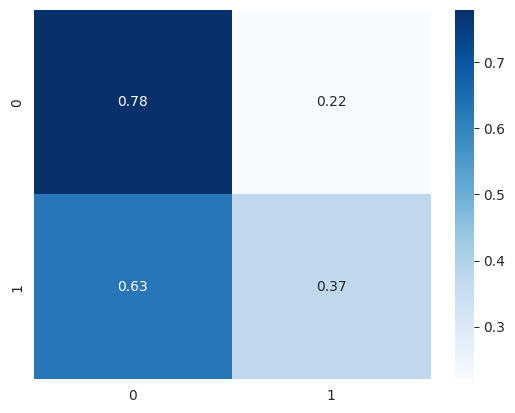

In [127]:
cm_smote = confusion_matrix(y_test, y_test_pred_smote, normalize='true')
sns.heatmap(cm_smote, annot=True, fmt=".2f", cmap='Blues')

## **4. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [109]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [110]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2024-12-27 16:59:06,149] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [111]:
study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-27 17:00:14,204] Trial 5 finished with value: 0.19653885559841838 and parameters: {'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.20896902 0.19211599 0.19778271 0.19019019 0.19363636]
Average F1-score: 0.19653885559841838


[I 2024-12-27 17:00:15,612] Trial 7 finished with value: 0.19077515479740953 and parameters: {'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.20910781 0.18904508 0.18932715 0.18307768 0.18331806]
Average F1-score: 0.19077515479740953


[I 2024-12-27 17:00:19,655] Trial 2 finished with value: 0.15100575657722634 and parameters: {'max_depth': 16, 'min_samples_leaf': 38}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.17045455 0.15344939 0.14614878 0.13692946 0.14804661]
Average F1-score: 0.15100575657722634


[I 2024-12-27 17:00:20,337] Trial 9 finished with value: 0.1703297466253517 and parameters: {'max_depth': 14, 'min_samples_leaf': 52}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.17772512 0.17586207 0.17068864 0.16906475 0.15830816]
Average F1-score: 0.1703297466253517


[I 2024-12-27 17:00:22,831] Trial 1 finished with value: 0.1432491194577901 and parameters: {'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.14911081 0.14886731 0.14276184 0.13561644 0.1398892 ]
Average F1-score: 0.1432491194577901


[I 2024-12-27 17:00:23,784] Trial 4 finished with value: 0.16023007837635378 and parameters: {'max_depth': 16, 'min_samples_leaf': 46}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.17923362 0.15558344 0.15559772 0.15436242 0.15637319]
Average F1-score: 0.16023007837635378


[I 2024-12-27 17:00:24,317] Trial 3 finished with value: 0.15475283973959958 and parameters: {'max_depth': 20, 'min_samples_leaf': 58}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.17164654 0.13888889 0.1669736  0.14051215 0.15574302]
Average F1-score: 0.15475283973959958


[I 2024-12-27 17:00:25,924] Trial 11 finished with value: 0.1524711961359103 and parameters: {'max_depth': 24, 'min_samples_leaf': 54}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.16688228 0.1446384  0.15091774 0.1527027  0.14721485]
Average F1-score: 0.1524711961359103


[I 2024-12-27 17:00:26,245] Trial 10 finished with value: 0.1439158341694969 and parameters: {'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.15792966 0.13890675 0.13868117 0.14140041 0.14266118]
Average F1-score: 0.1439158341694969


[I 2024-12-27 17:00:27,217] Trial 6 finished with value: 0.13975901726077145 and parameters: {'max_depth': 22, 'min_samples_leaf': 44}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.14401077 0.13561554 0.14976174 0.13333333 0.13607371]
Average F1-score: 0.13975901726077145


[I 2024-12-27 17:00:29,242] Trial 0 finished with value: 0.10606108409503867 and parameters: {'max_depth': 24, 'min_samples_leaf': 22}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.10648148 0.10582822 0.1136543  0.10369207 0.10064935]
Average F1-score: 0.10606108409503867


[I 2024-12-27 17:00:32,746] Trial 8 finished with value: 0.0780953273969462 and parameters: {'max_depth': 30, 'min_samples_leaf': 12}. Best is trial 5 with value: 0.19653885559841838.


Cross validation F1-scores: [0.07666667 0.08381265 0.08404803 0.06802721 0.07792208]
Average F1-score: 0.0780953273969462


[I 2024-12-27 17:01:15,745] Trial 19 finished with value: 0.2077201681895068 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.2077201681895068.


Cross validation F1-scores: [0.21246214 0.20759271 0.20727432 0.21256932 0.19870235]
Average F1-score: 0.2077201681895068


[I 2024-12-27 17:01:18,205] Trial 21 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 21 with value: 0.20807931060963117.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:01:26,623] Trial 22 finished with value: 0.21059044869947963 and parameters: {'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22032967 0.2118471  0.21139133 0.20988015 0.199504  ]
Average F1-score: 0.21059044869947963


[I 2024-12-27 17:01:28,471] Trial 17 finished with value: 0.20777480507400928 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22417751 0.20881503 0.20275591 0.20220588 0.2009197 ]
Average F1-score: 0.20777480507400928


[I 2024-12-27 17:01:32,076] Trial 23 finished with value: 0.21059044869947963 and parameters: {'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22032967 0.2118471  0.21139133 0.20988015 0.199504  ]
Average F1-score: 0.21059044869947963


[I 2024-12-27 17:01:32,522] Trial 13 finished with value: 0.15013463047579068 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.16135329 0.14745973 0.15074024 0.14854828 0.14257162]
Average F1-score: 0.15013463047579068


[I 2024-12-27 17:01:36,454] Trial 14 finished with value: 0.1542000970513051 and parameters: {'max_depth': 16, 'min_samples_leaf': 40}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.17164654 0.15636822 0.15251989 0.14382632 0.14663951]
Average F1-score: 0.1542000970513051


[I 2024-12-27 17:01:38,892] Trial 15 finished with value: 0.1245179250473802 and parameters: {'max_depth': 16, 'min_samples_leaf': 12}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.12445731 0.12086331 0.13227894 0.12481203 0.12017804]
Average F1-score: 0.1245179250473802


[I 2024-12-27 17:01:39,787] Trial 16 finished with value: 0.14774266401079864 and parameters: {'max_depth': 16, 'min_samples_leaf': 32}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.16461439 0.14427531 0.14486922 0.14472777 0.14022663]
Average F1-score: 0.14774266401079864


[I 2024-12-27 17:01:41,917] Trial 12 finished with value: 0.056727658219363264 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.05770965 0.05530776 0.04757548 0.05770965 0.06533575]
Average F1-score: 0.056727658219363264


[I 2024-12-27 17:01:44,279] Trial 18 finished with value: 0.12037825923930726 and parameters: {'max_depth': 30, 'min_samples_leaf': 30}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.12271731 0.10727406 0.12622089 0.13017751 0.11550152]
Average F1-score: 0.12037825923930726


[I 2024-12-27 17:01:46,946] Trial 20 finished with value: 0.10606108409503867 and parameters: {'max_depth': 24, 'min_samples_leaf': 22}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.10648148 0.10582822 0.1136543  0.10369207 0.10064935]
Average F1-score: 0.10606108409503867


[I 2024-12-27 17:02:08,276] Trial 24 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:11,093] Trial 25 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:18,665] Trial 26 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:22,551] Trial 27 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:34,524] Trial 32 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:35,894] Trial 33 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:37,892] Trial 34 finished with value: 0.20807931060963117 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21255411 0.20603675 0.21134492 0.21091243 0.19954835]
Average F1-score: 0.20807931060963117


[I 2024-12-27 17:02:39,553] Trial 28 finished with value: 0.20682542410720378 and parameters: {'max_depth': 8, 'min_samples_leaf': 18}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22102232 0.20779221 0.21121352 0.20070285 0.19339623]
Average F1-score: 0.20682542410720378


[I 2024-12-27 17:02:40,289] Trial 29 finished with value: 0.20682542410720378 and parameters: {'max_depth': 8, 'min_samples_leaf': 18}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22102232 0.20779221 0.21121352 0.20070285 0.19339623]
Average F1-score: 0.20682542410720378


[I 2024-12-27 17:02:40,988] Trial 35 finished with value: 0.20831437287548207 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21250812 0.20603675 0.21129659 0.21275605 0.19897436]
Average F1-score: 0.20831437287548207


[I 2024-12-27 17:02:44,301] Trial 30 finished with value: 0.20799508589437435 and parameters: {'max_depth': 8, 'min_samples_leaf': 16}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.22245838 0.20581818 0.21090387 0.20286396 0.19793103]
Average F1-score: 0.20799508589437435


[I 2024-12-27 17:02:46,920] Trial 31 finished with value: 0.20709289188332955 and parameters: {'max_depth': 8, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.21059044869947963.


Cross validation F1-scores: [0.21712204 0.21204472 0.21415608 0.19506641 0.19707521]
Average F1-score: 0.20709289188332955


[I 2024-12-27 17:03:10,152] Trial 36 finished with value: 0.2115719298785394 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22271839 0.21560035 0.21127159 0.20902214 0.19924718]
Average F1-score: 0.2115719298785394


[I 2024-12-27 17:03:19,093] Trial 37 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:03:26,256] Trial 38 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:03:35,787] Trial 39 finished with value: 0.19265706298516408 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.20852221 0.1928702  0.19114878 0.18286814 0.18787598]
Average F1-score: 0.19265706298516408


[I 2024-12-27 17:03:40,721] Trial 40 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:03:41,287] Trial 44 finished with value: 0.21154933196964576 and parameters: {'max_depth': 6, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22276688 0.21173695 0.21058559 0.21142521 0.20123203]
Average F1-score: 0.21154933196964576


[I 2024-12-27 17:03:42,409] Trial 45 finished with value: 0.21154933196964576 and parameters: {'max_depth': 6, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22276688 0.21173695 0.21058559 0.21142521 0.20123203]
Average F1-score: 0.21154933196964576


[I 2024-12-27 17:03:42,769] Trial 41 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:03:44,983] Trial 42 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:03:45,416] Trial 46 finished with value: 0.2110564821690716 and parameters: {'max_depth': 6, 'min_samples_leaf': 28}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22477441 0.21329562 0.20667031 0.21269941 0.19784267]
Average F1-score: 0.2110564821690716


[I 2024-12-27 17:03:47,572] Trial 47 finished with value: 0.21108435371372022 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.
[I 2024-12-27 17:03:47,636] Trial 43 finished with value: 0.2071096947861128 and parameters: {'max_depth': 8, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22162741 0.21234019 0.21146644 0.2106861  0.19930164]
Average F1-score: 0.21108435371372022
Cross validation F1-scores: [0.22458716 0.20457187 0.21041056 0.19890368 0.19707521]
Average F1-score: 0.2071096947861128


[I 2024-12-27 17:04:21,598] Trial 48 finished with value: 0.19469780895951122 and parameters: {'max_depth': 10, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.21007686 0.19078341 0.19328494 0.18624642 0.19309742]
Average F1-score: 0.19469780895951122


[I 2024-12-27 17:04:34,470] Trial 49 finished with value: 0.17555159513680588 and parameters: {'max_depth': 12, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.19393283 0.18191604 0.17943337 0.15770609 0.16476965]
Average F1-score: 0.17555159513680588


[I 2024-12-27 17:04:35,912] Trial 51 finished with value: 0.21108435371372022 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22162741 0.21234019 0.21146644 0.2106861  0.19930164]
Average F1-score: 0.21108435371372022


[I 2024-12-27 17:04:40,673] Trial 52 finished with value: 0.21108435371372022 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.
[I 2024-12-27 17:04:40,771] Trial 50 finished with value: 0.17788182376455883 and parameters: {'max_depth': 12, 'min_samples_leaf': 28}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22162741 0.21234019 0.21146644 0.2106861  0.19930164]
Average F1-score: 0.21108435371372022
Cross validation F1-scores: [0.2        0.17522985 0.17677824 0.15995397 0.17744705]
Average F1-score: 0.17788182376455883


[I 2024-12-27 17:04:42,795] Trial 53 finished with value: 0.21058219094766387 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22216082 0.20952945 0.2091764  0.20852804 0.20351625]
Average F1-score: 0.21058219094766387


[I 2024-12-27 17:04:43,479] Trial 54 finished with value: 0.21058219094766387 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22216082 0.20952945 0.2091764  0.20852804 0.20351625]
Average F1-score: 0.21058219094766387


[I 2024-12-27 17:04:46,189] Trial 56 finished with value: 0.21058219094766387 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22216082 0.20952945 0.2091764  0.20852804 0.20351625]
Average F1-score: 0.21058219094766387


[I 2024-12-27 17:04:58,286] Trial 55 finished with value: 0.17054676621123813 and parameters: {'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.18499718 0.1723356  0.16835017 0.15347432 0.17357656]
Average F1-score: 0.17054676621123813


[I 2024-12-27 17:05:01,229] Trial 57 finished with value: 0.16851177924364386 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.17847183 0.17033277 0.16494845 0.1588785  0.16992733]
Average F1-score: 0.16851177924364386


[I 2024-12-27 17:05:03,148] Trial 58 finished with value: 0.17555159513680588 and parameters: {'max_depth': 12, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.19393283 0.18191604 0.17943337 0.15770609 0.16476965]
Average F1-score: 0.17555159513680588


[I 2024-12-27 17:05:06,196] Trial 59 finished with value: 0.15680450404715665 and parameters: {'max_depth': 14, 'min_samples_leaf': 26}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.1662531  0.15345912 0.15607985 0.14952077 0.15870968]
Average F1-score: 0.15680450404715665


[I 2024-12-27 17:05:35,621] Trial 61 finished with value: 0.21058219094766387 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22216082 0.20952945 0.2091764  0.20852804 0.20351625]
Average F1-score: 0.21058219094766387


[I 2024-12-27 17:05:36,496] Trial 62 finished with value: 0.21058219094766387 and parameters: {'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.22216082 0.20952945 0.2091764  0.20852804 0.20351625]
Average F1-score: 0.21058219094766387


[I 2024-12-27 17:05:37,732] Trial 60 finished with value: 0.16851177924364386 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.2115719298785394.


Cross validation F1-scores: [0.17847183 0.17033277 0.16494845 0.1588785  0.16992733]
Average F1-score: 0.16851177924364386


[I 2024-12-27 17:05:41,551] Trial 64 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:05:42,666] Trial 63 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:05:56,378] Trial 66 finished with value: 0.17767214704345863 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.18946248 0.18623901 0.17824934 0.15259173 0.18181818]
Average F1-score: 0.17767214704345863


[I 2024-12-27 17:06:01,485] Trial 67 finished with value: 0.18142924829529314 and parameters: {'max_depth': 12, 'min_samples_leaf': 34}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20010532 0.17615467 0.18800813 0.16666667 0.17621145]
Average F1-score: 0.18142924829529314


[I 2024-12-27 17:06:02,900] Trial 65 finished with value: 0.13026477860493912 and parameters: {'max_depth': 20, 'min_samples_leaf': 34}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.13519164 0.12674095 0.14090582 0.12573099 0.12275449]
Average F1-score: 0.13026477860493912


[I 2024-12-27 17:06:16,675] Trial 68 finished with value: 0.13431752687362772 and parameters: {'max_depth': 18, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14145658 0.13424658 0.13617607 0.12418773 0.13552068]
Average F1-score: 0.13431752687362772


[I 2024-12-27 17:06:20,680] Trial 69 finished with value: 0.1338330104391915 and parameters: {'max_depth': 20, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14147018 0.13105802 0.14193548 0.12870571 0.12599566]
Average F1-score: 0.1338330104391915


[I 2024-12-27 17:06:22,628] Trial 70 finished with value: 0.13431752687362772 and parameters: {'max_depth': 18, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14145658 0.13424658 0.13617607 0.12418773 0.13552068]
Average F1-score: 0.13431752687362772


[I 2024-12-27 17:06:26,148] Trial 71 finished with value: 0.13026477860493912 and parameters: {'max_depth': 20, 'min_samples_leaf': 34}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.13519164 0.12674095 0.14090582 0.12573099 0.12275449]
Average F1-score: 0.13026477860493912


[I 2024-12-27 17:06:47,471] Trial 74 finished with value: 0.19971702789659523 and parameters: {'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22028733 0.20123023 0.19554343 0.19078341 0.19074074]
Average F1-score: 0.19971702789659523


[I 2024-12-27 17:06:54,690] Trial 72 finished with value: 0.13431752687362772 and parameters: {'max_depth': 18, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14145658 0.13424658 0.13617607 0.12418773 0.13552068]
Average F1-score: 0.13431752687362772


[I 2024-12-27 17:06:56,706] Trial 73 finished with value: 0.1338330104391915 and parameters: {'max_depth': 20, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14147018 0.13105802 0.14193548 0.12870571 0.12599566]
Average F1-score: 0.1338330104391915


[I 2024-12-27 17:07:00,322] Trial 75 finished with value: 0.13026477860493912 and parameters: {'max_depth': 20, 'min_samples_leaf': 34}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.13519164 0.12674095 0.14090582 0.12573099 0.12275449]
Average F1-score: 0.13026477860493912


[I 2024-12-27 17:07:01,758] Trial 76 finished with value: 0.1338330104391915 and parameters: {'max_depth': 20, 'min_samples_leaf': 36}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.14147018 0.13105802 0.14193548 0.12870571 0.12599566]
Average F1-score: 0.1338330104391915


[I 2024-12-27 17:07:06,186] Trial 77 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:14,998] Trial 79 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:21,007] Trial 78 finished with value: 0.14236570608238547 and parameters: {'max_depth': 18, 'min_samples_leaf': 42}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.15686275 0.12881806 0.15404531 0.1369863  0.13511612]
Average F1-score: 0.14236570608238547


[I 2024-12-27 17:07:28,484] Trial 80 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:32,645] Trial 81 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:34,784] Trial 82 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:38,537] Trial 83 finished with value: 0.19386514757968745 and parameters: {'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.20670648 0.19727572 0.18982118 0.18394161 0.19158076]
Average F1-score: 0.19386514757968745


[I 2024-12-27 17:07:49,146] Trial 84 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:07:57,498] Trial 85 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:07:59,204] Trial 86 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:08:03,306] Trial 87 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:08:04,765] Trial 88 finished with value: 0.21194326155895649 and parameters: {'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 63 with value: 0.21194326155895649.


Cross validation F1-scores: [0.22185971 0.20989505 0.2122807  0.21219091 0.20348993]
Average F1-score: 0.21194326155895649


[I 2024-12-27 17:08:08,197] Trial 89 finished with value: 0.2130904005882733 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22560478 0.21195039 0.21177149 0.21287554 0.20324979]
Average F1-score: 0.2130904005882733


[I 2024-12-27 17:08:16,003] Trial 90 finished with value: 0.20933596220345682 and parameters: {'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.21925134 0.2109174  0.21105826 0.20734214 0.19811066]
Average F1-score: 0.20933596220345682


[I 2024-12-27 17:08:21,877] Trial 91 finished with value: 0.21152708794473715 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22154359 0.21374046 0.21275328 0.21070615 0.19889197]
Average F1-score: 0.21152708794473715


[I 2024-12-27 17:08:26,026] Trial 92 finished with value: 0.2094360621854669 and parameters: {'max_depth': 6, 'min_samples_leaf': 30}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.2210783  0.20990764 0.20610687 0.21135266 0.19873484]
Average F1-score: 0.2094360621854669


[I 2024-12-27 17:08:28,721] Trial 93 finished with value: 0.2130904005882733 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22560478 0.21195039 0.21177149 0.21287554 0.20324979]
Average F1-score: 0.2130904005882733


[I 2024-12-27 17:08:30,327] Trial 94 finished with value: 0.2130904005882733 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22560478 0.21195039 0.21177149 0.21287554 0.20324979]
Average F1-score: 0.2130904005882733


[I 2024-12-27 17:08:31,767] Trial 95 finished with value: 0.2130904005882733 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22560478 0.21195039 0.21177149 0.21287554 0.20324979]
Average F1-score: 0.2130904005882733


[I 2024-12-27 17:08:36,147] Trial 98 finished with value: 0.20797754307608277 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.21246214 0.20641501 0.20889664 0.21256932 0.19954461]
Average F1-score: 0.20797754307608277


[I 2024-12-27 17:08:36,373] Trial 96 finished with value: 0.2130904005882733 and parameters: {'max_depth': 6, 'min_samples_leaf': 24}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.22560478 0.21195039 0.21177149 0.21287554 0.20324979]
Average F1-score: 0.2130904005882733


[I 2024-12-27 17:08:37,885] Trial 99 finished with value: 0.20797754307608277 and parameters: {'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.21246214 0.20641501 0.20889664 0.21256932 0.19954461]
Average F1-score: 0.20797754307608277


[I 2024-12-27 17:08:39,595] Trial 97 finished with value: 0.20933596220345682 and parameters: {'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 89 with value: 0.2130904005882733.


Cross validation F1-scores: [0.21925134 0.2109174  0.21105826 0.20734214 0.19811066]
Average F1-score: 0.20933596220345682


In [112]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 89
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 24}
Best Value: 0.2130904005882733


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [113]:
optuna.visualization.plot_optimization_history(study)

In [114]:
optuna.visualization.plot_slice(study)

In [115]:
optuna.visualization.plot_param_importances(study)

In [116]:
optuna.visualization.plot_parallel_coordinate(study)

In [117]:
optuna.visualization.plot_contour(study)

In [118]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [119]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=24,
                                        random_state=38))])

In [120]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [121]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.70572575277817
Test accuracy:  0.7051294117647059


In [122]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.73      0.82     19312
      Early-readmission       0.14      0.42      0.21      1938

               accuracy                           0.71     21250
              macro avg       0.53      0.58      0.51     21250
           weighted avg       0.85      0.71      0.76     21250



<Axes: >

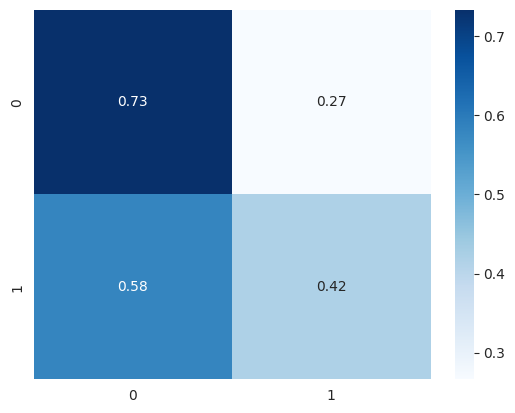

In [128]:
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')
sns.heatmap(cm_smotetomek, annot=True, fmt=".2f", cmap='Blues')

## **5. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

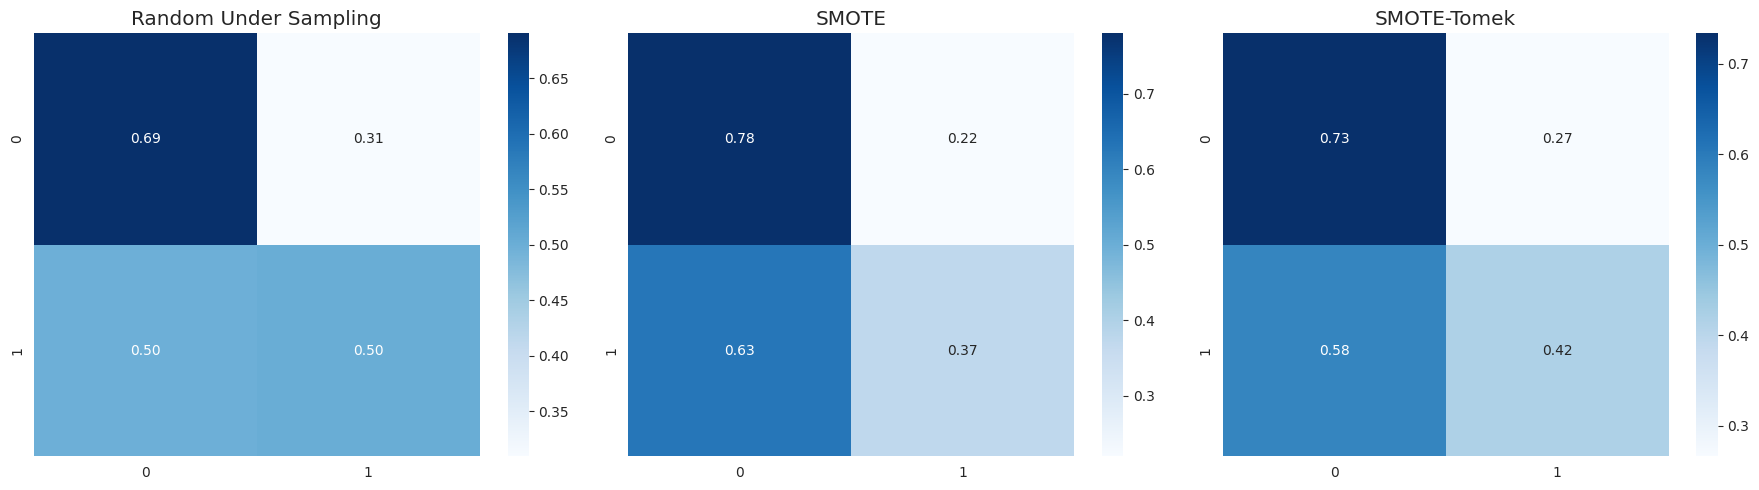

In [130]:
# Combine all confusion matrices into a single plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
cm_list = [cm_rus, cm_smote, cm_smotetomek]
titles = ['Random Under Sampling', 'SMOTE', 'SMOTE-Tomek']

for i, cm in enumerate(cm_list):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()